In [1]:
%matplotlib widget
import jungfrau_utils as ju
import numpy as np
import json, h5py, copy
import os, glob
import time
import pandas as pd
from matplotlib import pyplot as plt
from matplotlib import cm
from scipy.optimize import curve_fit
from IPython.display import clear_output, display
import matplotlib.colors as colors
import matplotlib.ticker as ticker
from ipyfilechooser import FileChooser
from scipy.stats.stats import pearsonr

from alvra_tools.load_data import *
from alvra_tools.channels import *

from alvra_tools.utils import *
from alvra_tools.XAS_functions import *

import warnings
warnings.filterwarnings('ignore')

## choose the run number

In [2]:
pgroup='p21210'
runnumber = 325
print ('run: {:04d}'.format(runnumber))

#############################################################
jsonfile = ''
jsonfile = glob.glob('/sf/alvra/data/{}/raw/*{:04d}*/meta/scan.json'.format(pgroup, runnumber))[0]
titlestring = str( pgroup + ' --- ' +jsonfile.split('/')[-3])
run_name = jsonfile.split('/')[-3]
jsonfile

run: 0325


'/sf/alvra/data/p21210/raw/run0325-XANES_CuNi_Ni_400nm_200fs/meta/scan.json'

In [3]:
quantile_corr = 0.6

detector_XAS = channel_diode_1
detector_Izero = channel_Izero122

reducedir='../Claudio/Reduced_XANES/'
saveflag = False

#######################################################################################################33
from sfdata import SFScanInfo
scan = SFScanInfo(jsonfile)
scan = remove_JF_from_scan(scan)

(DataDiode1_pump, DataDiode1_unpump, Pump_probe_Diode1,
 Izero_pump_scan, Izero_unpump_scan, correlation, Energy_eV, goodshots1) = \
XAS_scanPP_1diode_noTT(scan, detector_XAS, detector_Izero, quantile_corr)

if saveflag:
    os.makedirs(reducedir+run_name, exist_ok=True)
    save_data_XANES(reducedir, run_name, Energy_eV, 
                    DataDiode1_pump, DataDiode1_unpump, Pump_probe_Diode1, goodshots1)

Processing: run0325-XANES_CuNi_Ni_400nm_200fs
Step 109 of 109: Processing acq0109

--------------------------------------------------------------------------------

SAR-CVME-TIFALL4:EvtSet      1001 / 1001 -> 0% loss ▇▇▇▇▇▇▇▇▇▇
SARES11-GES1:PR1_CH1_VAL_GET 1001 / 1001 -> 0% loss ▇▇▇▇▇▇▇▇▇▇
SAROP11-PBPS122:INTENSITY     961 / 1001 -> 4% loss ▇▇▇▇▇▇▇▇▇

over the whole data set: 961 / 1001 -> 4% loss
complete channels: 2 / 3 -> 33% incomplete

--------------------------------------------------------------------------------

FEL rep rate is 100.0 Hz
Laser rep rate is 50.0 Hz (delayed or dark)
Pump scheme is 1:1
Loaded 459 pump and 459 unpump shots
166 shots out of 459 survived
Step 109 of 109: Processed acq0109
correlation Diode (all shots) = 0.9987849763438141
------------------------------
Processed 109 out of 109 files


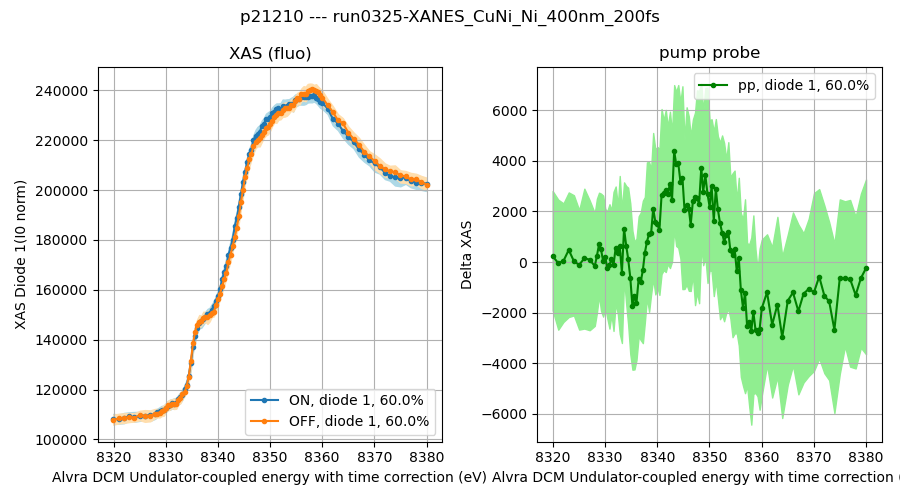

In [4]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(9, 5), constrained_layout=True)
plt.suptitle(titlestring)

XAS_pump = DataDiode1_pump[:,0]
err_low_pump = DataDiode1_pump[:,1]
err_high_pump = DataDiode1_pump[:,2]
XAS_unpump = DataDiode1_unpump[:,0]
err_low_unpump = DataDiode1_unpump[:,1]
err_high_unpump = DataDiode1_unpump[:,2]
XAS_pump_probe = Pump_probe_Diode1[:,0]
err_low_pump_probe = Pump_probe_Diode1[:,1]
err_high_pump_probe = Pump_probe_Diode1[:,2]

units = scan.parameters['units'][0]
label = scan.parameters['name'][0]

ax1.plot(Energy_eV, XAS_pump, label='ON, diode 1, {}%'.format(quantile_corr*100),marker='.')
ax1.fill_between(Energy_eV, err_low_pump, err_high_pump, color='lightblue')

ax1.plot(Energy_eV, XAS_unpump, label='OFF, diode 1, {}%'.format(quantile_corr*100),marker='.')
ax1.fill_between(Energy_eV, err_low_unpump, err_high_unpump, color='navajowhite')

ax1.set_xlabel("{} ({})".format(label, units))
ax1.set_ylabel ("XAS Diode 1(I0 norm)")
ax1.set_title('XAS (fluo)')
ax1.legend(loc="best")
ax1.grid()

#print(type(Energy_eV))
#Energy_eV = np.sort(Energy_eV)

ax2.plot(Energy_eV, XAS_pump_probe, label='pp, diode 1, {}%'.format(quantile_corr*100),marker='.', color = 'g')
ax2.fill_between(Energy_eV, err_low_pump_probe, err_high_pump_probe, color='lightgreen')

#ax3=ax2.twinx()
#ax3.plot(Energy_eV, XAS_pump_probe/XAS_unpump,marker='.', color = 'c')

ax2.set_xlabel("{} ({})".format(label, units))
ax2.set_ylabel ("Delta XAS")
ax2.set_title('pump probe')
ax2.legend(loc="best")
ax2.grid()

plt.tight_layout()
plt.show()

## Error Bars

In [5]:
#### CH1 ####
XAS1_pump      = DataDiode1_pump[:,0]
err1_low_pump  = (DataDiode1_pump[:,1]-DataDiode1_pump[:,0])/np.sqrt(goodshots1)
err1_high_pump = (DataDiode1_pump[:,2]-DataDiode1_pump[:,0])/np.sqrt(goodshots1)

XAS1_unpump      = DataDiode1_unpump[:,0]
err1_low_unpump  = (DataDiode1_unpump[:,1]-DataDiode1_unpump[:,0])/np.sqrt(goodshots1)
err1_high_unpump = (DataDiode1_unpump[:,2]-DataDiode1_unpump[:,0])/np.sqrt(goodshots1)

XAS1_pump_probe       = Pump_probe_Diode1[:,0]
err1_low_pump_probe   = np.sqrt(err1_low_pump**2  + err1_low_unpump**2)
err1_high_pump_probe  = np.sqrt(err1_high_pump**2 + err1_high_unpump**2)

## Plotting XANES with error bars

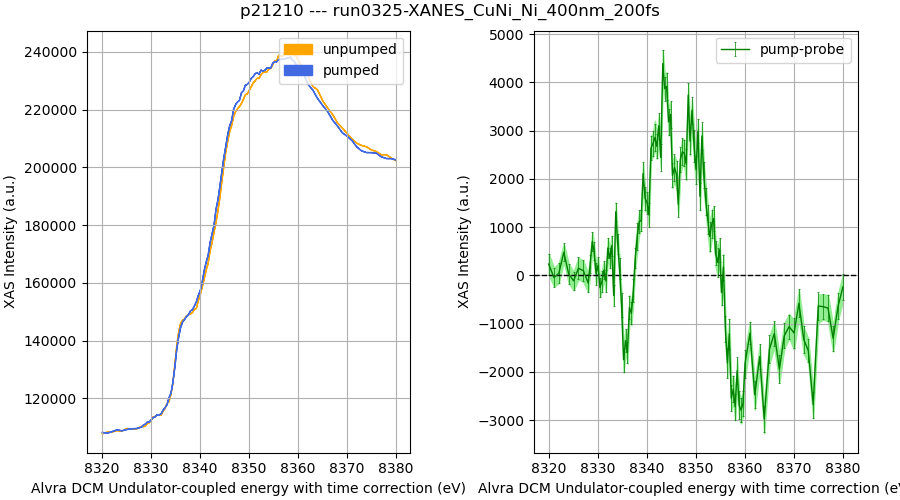

In [6]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(9, 5), constrained_layout=True)
plt.suptitle(titlestring, fontsize = 12)

#ax1.plot(Energy_eV,XAS1_pump,lw=1,marker='o',markersize=3,label='unpumped')
ax1.fill_between(Energy_eV,XAS1_unpump-err1_low_unpump, XAS1_unpump+err1_high_unpump,color='orange',label='unpumped')
ax1.fill_between(Energy_eV,XAS1_pump-err1_low_pump, XAS1_pump+err1_high_pump,color='royalblue',label='pumped')


ax1.set_xlabel("{} ({})".format(label, units))
ax1.set_ylabel('XAS Intensity (a.u.)')
ax1.legend()
ax1.grid()
#ax1.set_xlim(7110,7150)

## Difference of the Averages (probably more correct)
ax2.axes.errorbar(Energy_eV, XAS1_pump_probe, (err1_low_pump_probe+err1_high_pump_probe)/2, 
              lw=1,color='green', markersize=0,capsize=1,capthick=0.5,
                   ecolor='green',elinewidth=0.5,label='pump-probe')
#ax2.plot(Energy_eV,ave_pp1,lw=1,marker='o',markersize=3,color='green',label='unpumped')
ax2.fill_between(Energy_eV,XAS1_pump_probe-err1_low_pump_probe, XAS1_pump_probe+err1_high_pump_probe,color='lightgreen')


ax2.axhline(0,ls='--',c='k',lw=1)
ax2.set_xlabel("{} ({})".format(label, units))
ax2.set_ylabel('XAS Intensity (a.u.)')
ax2.legend()
ax2.grid()

## Check correlation for a certain energy point

In [10]:
chosen_energy = 7117.5

detector_XAS = channel_diode_2
detector_Izero = channel_Izero110

quantile_corr = 0.6
##################################################################
from sfdata import SFScanInfo
scan = SFScanInfo(jsonfile)
scan = remove_JF_from_scan(scan)

index_energy = np.arange(len(Energy_eV))[(Energy_eV > chosen_energy)][0]

Fluo_pump, Fluo_unpump, Izero_pump, Izero_unpump, correlation_filter = \
Get_correlation_from_scan2(scan, index_energy, detector_XAS, detector_Izero, quantile_corr)

arrays_to_filter = ["Fluo_pump", "Fluo_unpump", "Izero_pump", "Izero_unpump"]
arrays_filtered = apply_filter(correlation_filter, arrays_to_filter, globals_dict=globals())

print ('{} shots out of {} survived'.format(np.shape(Fluo_pump_filter), np.shape(Fluo_pump)))
print ('Correlation (all shots)      = {}'.format(pearsonr(Izero_pump,Fluo_pump)[0]))
print ('Correlation (filtered shots) = {}'.format(pearsonr(Izero_pump_filter,Fluo_pump_filter)[0]))
print ('Energy = {} eV'.format(Energy_eV[index_energy]))

(351,) shots out of (964,) survived
Correlation (all shots)      = 0.9721635725489521
Correlation (filtered shots) = 0.9960378843348608
Energy = 7117.948763891387 eV


In [8]:
chosen_energy = 7116

detector_XAS = channel_diode_2
detector_Izero = channel_Izero110

quantile_corr = 0.5
##################################################################3
from sfdata import SFScanInfo
scan = SFScanInfo(jsonfile)
scan = remove_JF_from_scan(scan)

index_energy = np.arange(len(Energy_eV))[(Energy_eV > chosen_energy)][0]

(Fluo_pump, Fluo_unpump, Izero_pump, Izero_unpump, 
 Fluo_pump_filter, Fluo_unpump_filter, Izero_pump_filter, Izero_unpump_filter) = \
Get_correlation_from_scan(scan, index_energy, detector_XAS, detector_Izero, quantile_corr)

print ('Correlation (all shots)      = {}'.format(pearsonr(Izero_pump,Fluo_pump)[0]))
print ('Correlation (filtered shots) = {}'.format(pearsonr(Izero_pump_filter,Fluo_pump_filter)[0]))
print ('Energy = {} eV'.format(Energy_eV[index_energy]))

(268,) shots out of (987,) survived
Correlation (all shots)      = 0.9749878888141944
Correlation (filtered shots) = 0.9965406419559145
Energy = 7117.014193897437 eV


In [11]:
from scipy import stats
#m,b = np.polyfit(Izero_pump,Fluo_pump, 1)
#m_filter,b_filter = np.polyfit(Izero_pump_filter,Fluo_pump_filter, 1)
m_median = np.median(Fluo_pump/Izero_pump)
m_median_filter = np.median(Fluo_pump_filter/Izero_pump_filter)
print ("Median (all) = {}, Median (filtered) = {}".format(m_median, m_median_filter))

MAD = stats.median_absolute_deviation(Fluo_pump/Izero_pump)
MAD_filter = stats.median_absolute_deviation(Fluo_pump_filter/Izero_pump_filter)

print ("MAD (all) = {}, MAD(filtered) = {}".format(MAD, MAD_filter))

print ("MAD/median (all) = {}%, MAD/median (filtered) = {}%".format(MAD/m_median*100, MAD_filter/m_median_filter*100))

Median (all) = 61541.03626676007, Median (filtered) = 61466.38444335432
MAD (all) = 4985.189976074098, MAD(filtered) = 3365.144378139136
MAD/median (all) = 8.100594787622596%, MAD/median (filtered) = 5.474771956434752%


(240,) shots out of (964,) survived


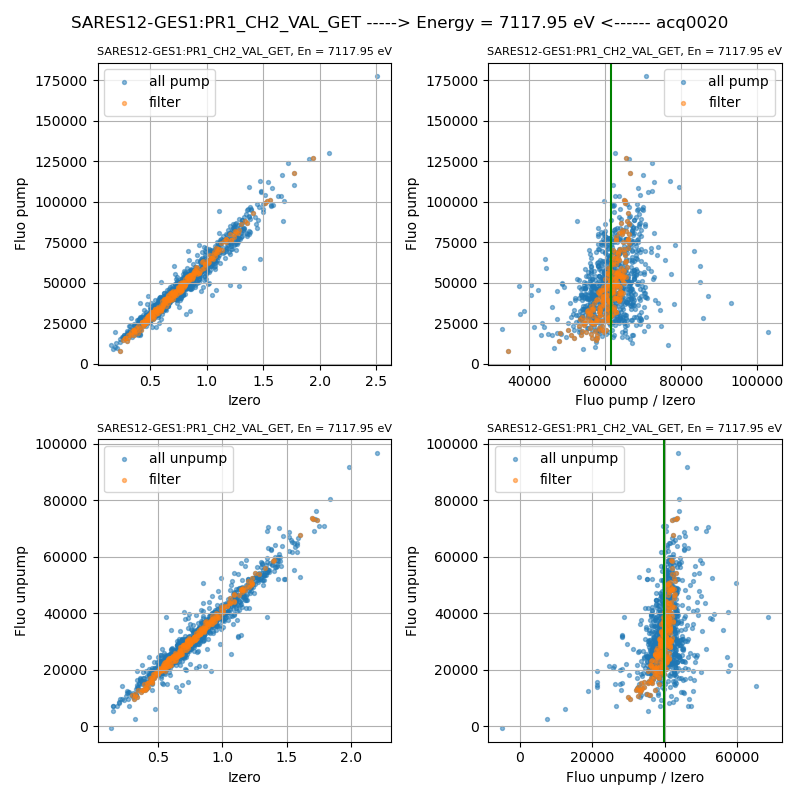

In [12]:
#chosen_energy = 2472

detector_XAS = channel_diode_2
detector_Izero = channel_Izero110

quantile_corr = 0.5
##################################################################3
from sfdata import SFScanInfo
scan = SFScanInfo(jsonfile)
scan = remove_JF_from_scan(scan)

index_energy = np.arange(len(Energy_eV))[(Energy_eV > chosen_energy)][0]

# (Fluo_pump, Fluo_unpump, Izero_pump, Izero_unpump, 
#  Fluo_pump_filter, Fluo_unpump_filter, Izero_pump_filter, Izero_unpump_filter) = \
# Get_correlation_from_scan(scan, index_energy, detector_XAS, detector_Izero, quantile_corr)

Fluo_pump, Fluo_unpump, Izero_pump, Izero_unpump, correlation_filter = \
Get_correlation_from_scan2(scan, index_energy, detector_XAS, detector_Izero, quantile_corr)
arrays_to_filter = ["Fluo_pump", "Fluo_unpump", "Izero_pump", "Izero_unpump"]
arrays_filtered = apply_filter(correlation_filter, arrays_to_filter, globals_dict=globals())

fig,ax = plt.subplots(2,2,figsize=(8,8))
plt.suptitle('{} -----> Energy = {:.2f} eV <------ {}'.format(detector_XAS,Energy_eV[index_energy], scan.files[index_energy][1].split('/')[-1].split('.')[0]))
ax0 = ax[0][0]
ax1 = ax[0][1]
ax2 = ax[1][0]
ax3 = ax[1][1]

ax0.set_title('{}, En = {:.2f} eV'.format(detector_XAS,Energy_eV[index_energy]),fontsize=8)
ax0.scatter(Izero_pump, Fluo_pump, s=8, alpha = 0.5,  label = 'all pump')
ax0.scatter(Izero_pump_filter, Fluo_pump_filter, s=8, alpha = 0.5, label='filter')
ax0.legend(loc='best')
ax0.set_xlabel('Izero')
ax0.set_ylabel('Fluo pump')
ax0.grid()

m_median_filter = np.median(Fluo_pump_filter/Izero_pump_filter)

ax1.set_title('{}, En = {:.2f} eV'.format(detector_XAS,Energy_eV[index_energy]),fontsize=8)
ax1.scatter(Fluo_pump/Izero_pump, Fluo_pump, s=8, alpha = 0.5,  label = 'all pump')
ax1.scatter(Fluo_pump_filter/Izero_pump_filter, Fluo_pump_filter, s=8, alpha = 0.5, label='filter')
ax1.legend(loc='best')
ax1.set_xlabel('Fluo pump / Izero')
ax1.set_ylabel('Fluo pump')
ax1.axvline(x=m_median_filter, color = 'green')
ax1.grid()

ax2.set_title('{}, En = {:.2f} eV'.format(detector_XAS,Energy_eV[index_energy]),fontsize=8)
ax2.scatter(Izero_unpump, Fluo_unpump, s=8, alpha = 0.5,  label = 'all unpump')
ax2.scatter(Izero_unpump_filter, Fluo_unpump_filter, s=8, alpha = 0.5, label='filter')
ax2.legend(loc='best')
ax2.set_xlabel('Izero')
ax2.set_ylabel('Fluo unpump')
ax2.grid()

m_median_filter = np.median(Fluo_unpump_filter/Izero_unpump_filter)

ax3.set_title('{}, En = {:.2f} eV'.format(detector_XAS,Energy_eV[index_energy]),fontsize=8)
ax3.scatter(Fluo_unpump/Izero_unpump, Fluo_unpump, s=8, alpha = 0.5,  label = 'all unpump')
ax3.scatter(Fluo_unpump_filter/Izero_unpump_filter, Fluo_unpump_filter, s=8, alpha = 0.5, label='filter')
ax3.legend(loc='best')
ax3.set_xlabel('Fluo unpump / Izero')
ax3.set_ylabel('Fluo unpump')
ax3.axvline(x=m_median_filter, color = 'green')
ax3.grid()

print ('{} shots out of {} survived'.format(np.shape(Fluo_pump_filter), np.shape(Fluo_pump)))
plt.tight_layout()

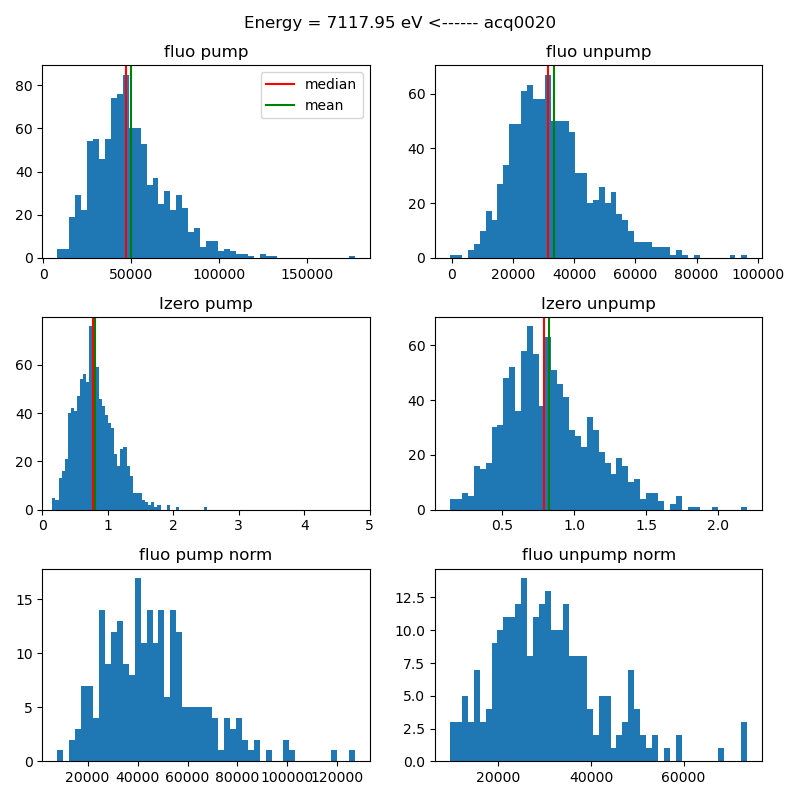

In [ ]:
plt.figure(figsize=(8,8))
plt.suptitle('Energy = {:.2f} eV <------ {}'.format(Energy_eV[index_energy], scan.files[index_energy][1].split('/')[-1].split('.')[0]))

plt.subplot(321)
plt.title('fluo pump')
plt.hist(Fluo_pump, bins = 50)
plt.axvline(x=np.median(Fluo_pump), color ='r',label='median')
plt.axvline(x=np.mean(Fluo_pump), color ='g', label = 'mean')
plt.legend(loc='best')

plt.subplot(322)
plt.title('fluo unpump')
plt.hist(Fluo_unpump, bins = 50)
plt.axvline(x=np.median(Fluo_unpump), color ='r')
plt.axvline(x=np.mean(Fluo_unpump), color ='g')

plt.subplot(323)
plt.title('Izero pump')
plt.hist(Izero_pump, bins = 50)
plt.axvline(x=np.median(Izero_pump), color ='r')
plt.axvline(x=np.mean(Izero_pump), color ='g')
plt.xlim(0,5)

plt.subplot(324)
plt.title('Izero unpump')
plt.hist(Izero_unpump, bins = 50)
plt.axvline(x=np.median(Izero_unpump), color ='r')
plt.axvline(x=np.mean(Izero_unpump), color ='g')

plt.subplot(325)
plt.title('fluo pump norm')
plt.hist(Fluo_pump_filter, bins = 50)
#plt.axvline(x=qnt_low_pump, color = 'black')
#plt.axvline(x=qnt_high_pump, color = 'black')
#plt.xlim(0,10)

plt.subplot(326)
plt.title('fluo unpump norm')
plt.hist(Fluo_unpump_filter, bins = 50)
#plt.axvline(x=qnt_low_pump, color = 'black')
#plt.axvline(x=qnt_high_pump, color = 'black')
#plt.xlim(0,10)


plt.tight_layout()
plt.show()

## Load files in a loop

In [ ]:
pgroup='p20269'

#runlist = []
runlist = np.arange(157, 160, 1)

print ('{} runs: {}'.format(len(runlist),runlist))

#############################################################
from itertools import chain
jsonlist = []
for run in runlist:
    file = glob.glob('/sf/alvra/data/{}/raw/*{:04d}*/meta/scan.json'.format(pgroup, run))
    jsonlist.append(file)
jsonlist = itertools.chain.from_iterable(jsonlist)
jsonlist = sorted(jsonlist, key = os.path.getmtime)
jsonlist

In [ ]:
quantile_corr = 0.4

detector_XAS = channel_diode_1
detector_Izero = channel_Izero110

reducedir='../Claudio/Reduced_XANES/'
saveflag=False
#######################################################################################################33
from sfdata import SFScanInfo

DataDiode1_pump_all = []
DataDiode1_unpump_all = []
Pump_probe1_all = []

for json_file in jsonlist:
    scan = SFScanInfo(json_file)
    scan = remove_JF_from_scan(scan)
    # Energy_eV = scan.readbacks
    
    DataDiode1_pump = []
    DataDiode1_unpump = []
    Pump_probe_Diode1 = []
    
    (DataDiode1_pump, DataDiode1_unpump, Pump_probe_Diode1,
     Izero_pump_scan, Izero_unpump_scan, correlation, Energy_eV, goodshots1) = \
    XAS_scanPP_1diode_noTT(scan, detector_XAS, detector_Izero, quantile_corr)
        
    DataDiode1_pump_all.append(DataDiode1_pump)
    DataDiode1_unpump_all.append(DataDiode1_unpump)
    Pump_probe1_all.append(Pump_probe_Diode1)    
    
    run_name = json_file.split('/')[-3]
    os.makedirs(reducedir+run_name, exist_ok=True)
    
    if saveflag:
        save_data_XANES(reducedir, run_name, Energy_eV,
                        DataDiode1_pump, DataDiode1_unpump, Pump_probe_Diode1, goodshots1)

DataDiode1_pump_all = np.array(DataDiode1_pump_all)
DataDiode1_unpump_all = np.array(DataDiode1_unpump_all)
Pump_probe1_all = np.array(Pump_probe1_all)


In [ ]:
def binned(x,n):
    f = np.divmod(len(x), n)[0]
    ret = np.zeros(f)
    for i in range(n):
        ret += x[i:n*f:n]
    return ret/n

In [ ]:
nscans = 7

XAS_pump = np.mean(DataDiode_pump_all[:nscans], axis=0)[:,0]
err_low_pump = np.mean(DataDiode_pump_all[:nscans], axis=0)[:,1]
err_high_pump = np.mean(DataDiode_pump_all[:nscans], axis=0)[:,2]
XAS_unpump = np.mean(DataDiode_unpump_all[:nscans], axis=0)[:,0]
err_low_unpump = np.mean(DataDiode_unpump_all[:nscans], axis=0)[:,1]
err_high_unpump = np.mean(DataDiode_unpump_all[:nscans], axis =0)[:,2]
XAS_pump_probe = np.mean(Pump_probe_all[:nscans], axis=0)[:,0]
err_low_pump_probe = np.mean(Pump_probe_all[:nscans], axis=0)[:,1]
err_high_pump_probe = np.mean(Pump_probe_all[:nscans], axis=0)[:,2]

fig, ax1 = plt.subplots()
# plt.title('{} files from loop {}'.format(len(patch), json_file.split('/')[-1][:-7]))
plt.title('{} files from loop {}'.format(nscans, json_file.split('/')[-1][:-7]))

ax2 = ax1.twinx()
ax1.plot(Energy_eV, XAS_pump, label='ON, {}%'.format(quantile_corr*100),marker='.')
ax1.fill_between(Energy_eV, err_low_pump, err_high_pump, color='lightblue')

ax1.plot(Energy_eV, XAS_unpump, label='OFF, {}%'.format(quantile_corr*100),marker='.')
ax1.fill_between(Energy_eV, err_low_unpump, err_high_unpump, color='navajowhite')

# ax2.plot(Energy_eV, XAS_pump_probe, label='pp, {}%'.format(quantile_corr*100),marker='.', color='g')
ax2.plot(binned(Energy_eV,2), binned(XAS_pump_probe,2), label='pp, {}%'.format(quantile_corr*100),marker='.', color='g')

ax1.legend(loc='best')
ax2.legend(loc='lower right')
ax1.set_xlabel('Energy (eV)')
ax1.set_ylabel('XAS norm')
ax2.set_ylabel('difference')

ratio = 100
ylim1 = ax1.get_ylim()
ylim2 = ax2.get_ylim()
ax1.set_ylim(ylim2[0]*ratio, ylim1[1])
ax2.set_ylim(ylim2[0], ylim1[1]/ratio)

ax1.grid()
plt.tight_layout()
plt.show()

In [ ]:
np.shape(DataDiode_pump_all)

In [ ]:
XAS_pump_all = DataDiode_pump_all[:,:,0]
XAS_unpump_all = DataDiode_unpump_all[:,:,0]
XAS_pump_probe_all = Pump_probe_all[:,:,0]

fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(15,6))
plt.title('{} files from loop {}'.format(len(patch), json_file.split('/')[-1][:-7]))

for ax in [ax1, ax2, ax3]:
    ax.set_prop_cycle('color',plt.cm.Spectral(np.linspace(0,1,10)))
    ax.set_xlabel('Energy (eV)')
    ax.grid()

for i in range(10):
    ax1.plot(Energy_eV, XAS_pump_all[i], label='run{:04d}'.format(123+i),marker='.')
    ax2.plot(Energy_eV, XAS_unpump_all[i], label='run{:04d}'.format(123+i),marker='.')
    ax3.plot(Energy_eV, XAS_pump_probe_all[i]/XAS_pump_all[i], label='pp, {}%'.format(quantile_corr*100),marker='.')

ax1.legend(loc='best', fontsize=9, ncol=2)
# ax2.legend(loc='lower right')

ax1.set_title('ON')
ax2.set_title('OFF')

ax1.set_ylabel('XAS norm')
ax2.set_ylabel('XAS norm')
ax3.set_title('difference')

ax3.set_ylim(-0.025,0.015)

plt.tight_layout()
plt.show()

In [ ]:
# np.save('/das/work/p20/p20537/victoria/FePhen_RXES_2ps_loop1/DataDiode_pump_all.npy', DataDiode_pump_all)
# np.save('/das/work/p20/p20537/victoria/FePhen_RXES_2ps_loop1/DataDiode_unpump_all.npy', DataDiode_unpump_all)
# np.save('/das/work/p20/p20537/victoria/FePhen_RXES_2ps_loop1/Pump_probe_all.npy', Pump_probe_all)
# np.save('/das/work/p20/p20537/victoria/FePhen_RXES_2ps_loop1/Energy_eV.npy', Energy_eV)

In [ ]:
DataDiode_pump_2ps_all = np.load('/das/work/p20/p20537/victoria/FePhen_RXES_2ps_loop1/DataDiode_pump_all.npy')
DataDiode_unpump_2ps_all = np.load('/das/work/p20/p20537/victoria/FePhen_RXES_2ps_loop1/DataDiode_unpump_all.npy')
Pump_probe_2ps_all = np.load('/das/work/p20/p20537/victoria/FePhen_RXES_2ps_loop1/Pump_probe_all.npy')
Energy_eV_2ps = np.load('/das/work/p20/p20537/victoria/FePhen_RXES_2ps_loop1/Energy_eV.npy')

## cell to export data

In [ ]:
import pandas as pd
DIR_save = "/das/work/p18/p18956/UserFolder/"
file2save = DIR_save + scan_name + ".txt"
pd.DataFrame({
    'Energy_eV' : Energy_eV,
    'pump_probe': Pump_probe,
    'signal_on' : DataFluo_pump,
    'signal_off' : DataFluo_unpump,
}).to_csv(file2save,index=False)